# Leveraging Big Data to Improve Insurance Complaint Handling

## Initialize Spark Session


In [0]:
# Importing libraries for data processing and machine learning
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, when, datediff, sum as spark_sum
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler, PCA
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.classification import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


# Starting a Spark session for processing large datasets
spark=SparkSession.builder.appName("InsuranceComplaintsAnalysis").getOrCreate()

## Loading Dataset using DBFS and Initial Data Cleaning

In [0]:
file_location="Insurance_Company_Complaints__Resolutions__Status__and_Recoveries__4_-3.csv"
file_type="csv"

# Read the dataset
insurance_df=spark.read.format(file_type) \
    .option("inferSchema", "true") \
    .option("header", "true") \
    .option("sep", ",") \
    .load(file_location)

# Display the loaded DataFrame
insurance_df.show(5)


from pyspark.sql.functions import when, col, datediff, to_date



### Data Cleaning

# Renaming columns to remove spaces for easier processing
insurance_df_renamed=insurance_df.withColumnRenamed("File No.","FileNo")

# Dropping rows with missing data to ensure quality
insurance_df_cleaned=insurance_df_renamed.dropna()

# Removing duplicate rows for consistency
insurance_df_no_duplicates=insurance_df_cleaned.dropDuplicates()

# Converting 'Opened' and 'Closed' columns to date format for analysis
insurance_df_transformed=insurance_df_no_duplicates.withColumn("Opened",to_date(col("Opened"),"MM/dd/yyyy"))
insurance_df_transformed=insurance_df_transformed.withColumn("Closed",to_date(col("Closed"),"MM/dd/yyyy"))

# Adding a 'Duration' column to calculate the time difference between 'Opened' and 'Closed'
insurance_df_transformed=insurance_df_transformed.withColumn("Duration",datediff(col("Closed"),col("Opened")))

# Categorizing complaint statuses into groups such as Open, Closed, or Other
insurance_df_transformed=insurance_df_transformed.withColumn("StatusGroup",when(col("Status")=="Open","OpenGroup")
                                             .when(col("Status")=="Closed","ClosedGroup")
                                             .otherwise("OtherGroup"))

# Showing the first 5 rows of the cleaned and transformed dataset
insurance_df_transformed.show(5)




+--------------------+--------+----------+----------+--------+-----------+-----------------+--------------------+--------------------+--------------------+--------+------+
|             Company|File No.|    Opened|    Closed|Coverage|SubCoverage|           Reason|           SubReason|         Disposition|          Conclusion|Recovery|Status|
+--------------------+--------+----------+----------+--------+-----------+-----------------+--------------------+--------------------+--------------------+--------+------+
|Anthem Health Pla...| 7045593|2022-05-31|2022-06-02|   Group|Health Only|   Claim Handling| Medically Necessary|Company Position ...|Company Position ...|     0.0|Closed|
|Anthem Health Pla...| 7043381|2022-02-28|2022-06-02|   Group|Health Only|   Claim Handling|Provider Contract...|       Claim Settled|           Satisfied|  6467.3|Closed|
|Anthem Health Pla...| 7044860|2022-05-03|2022-06-02|   A & H|Health Only|   Claim Handling|              Denial|       Claim Settled|      

## Correlation Analysis Between Duration and Recovery

In [0]:
# Calculating the correlation between 'Duration' and 'Recovery'
correlation_value=insurance_df_transformed.stat.corr('Duration','Recovery')
print(f"Correlation between Duration and Recovery: {correlation_value:.2f}")

Correlation between Duration and Recovery: 0.12


## Preparing Data for Exploratory Data Analysis (EDA)

In [0]:
### Exploratory Data Analysis (EDA)

# Converting Spark DataFrame to Pandas DataFrame for visualizations
if insurance_df_transformed.count()>0:
    pandas_df=insurance_df_transformed.toPandas()

## Filtering Columns and Advanced Preprocessing

In [0]:
# Data Preprocessing
pandas_df=pandas_df[['Company','FileNo','Opened','Closed','Coverage','SubCoverage','Reason', 
                       'SubReason','Disposition','Conclusion','Recovery','Status']]

# Convert dates and calculate resolution time
pandas_df['Opened']=pd.to_datetime(pandas_df['Opened'],errors='coerce')
pandas_df['Closed']=pd.to_datetime(pandas_df['Closed'],errors='coerce')
pandas_df['Resolution_Time_Days']=(pandas_df['Closed']-pandas_df['Opened']).dt.days.fillna(0)

# Drop original date columns and encode 'Disposition'
pandas_df=pandas_df.drop(columns=['Opened','Closed'])

label_encoder=LabelEncoder()
pandas_df['Disposition']=label_encoder.fit_transform(pandas_df['Disposition'])

## Visualizing Complaint Resolution Time Distribution

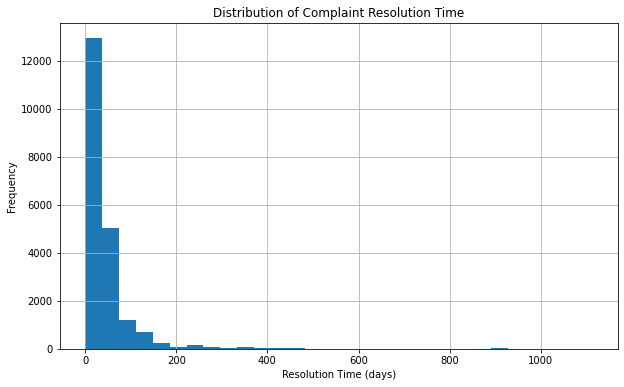

In [0]:
# Visualization 1: Distribution of Complaint Resolution Time
if 'Resolution_Time_Days' in pandas_df.columns and not pandas_df['Resolution_Time_Days'].isnull().all():
    plt.figure(figsize=(10,6))
    pandas_df['Resolution_Time_Days'].dropna().hist(bins=30)
    plt.xlabel('Resolution Time (days)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Complaint Resolution Time')
    plt.show()
else:
    print("'Resolution_Time_Days' column is missing or contains only null values.")


## Visualizing Distribution of Complaint Status

Out[7]: Text(0.5, 1.0, 'Distribution of Complaint Status')

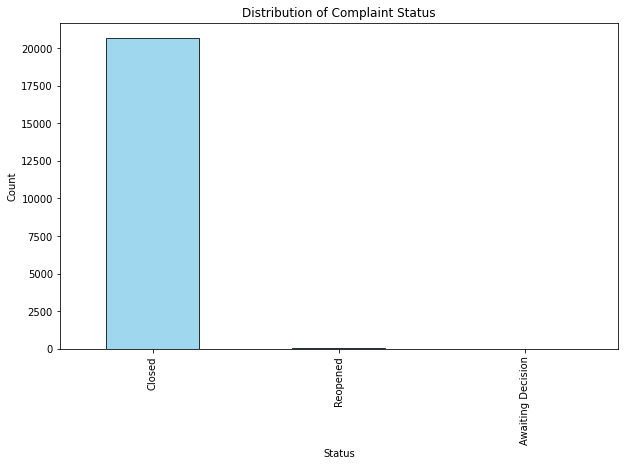

In [0]:
# Visualization 2: Distribution of Complaint Status
import matplotlib.pyplot as plt

status_counts=pandas_df['Status'].value_counts()

plt.figure(figsize=(10, 6))
ax = status_counts.plot(kind='bar',color='skyblue',edgecolor='black',alpha=0.8)
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Distribution of Complaint Status')

## Visualizing Average Recovery Amount by Coverage Type

Confidence Intervals for Recovery Amount by Coverage Type:
A & H: ±323.59
Builder's Risk: ±nan
Commercial: ±802.15
Commercial Multi-Peril: ±5632.55
Condo/Townhome: ±981.50
Credit Accident & Health: ±5185.67
Credit Life: ±0.00
Dwelling Fire: ±6655.29
Farm owner/Ranch owner: ±nan
Fire, Allied Lines: ±0.00
Group: ±340.70
Group Annuities: ±0.00
Group Life: ±367.41
Homeowners: ±1497.27
IRA: ±0.00
Individual: ±560.04
Individual Annuities: ±0.00
Individual Life: ±3636.78
Individual Private Passenger: ±134.33
Mobile Homeowner: ±0.00
Motorcycle: ±0.00
Motorhome: ±285.11
Motorsport: ±0.00
Professional/E&O: ±nan
Rental: ±557.40
Renter/Tenants: ±0.00


/databricks/python/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/databricks/python/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


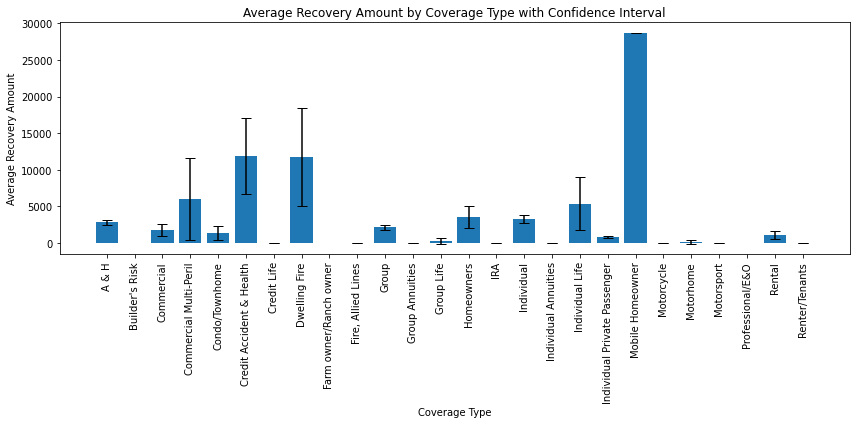

In [0]:
# Visualization 3: Average Recovery Amount by Coverage Type with Confidence Interval
if 'Recovery' in pandas_df.columns and 'Coverage' in pandas_df.columns and not pandas_df['Recovery'].isnull().all():
        plt.figure(figsize=(12, 6))
        recovery_means = pandas_df.groupby('Coverage')['Recovery'].mean()
        recovery_std = pandas_df.groupby('Coverage')['Recovery'].std()
        n = pandas_df.groupby('Coverage')['Recovery'].count()
        confidence_interval=1.96*(recovery_std / np.sqrt(n))

        print("Confidence Intervals for Recovery Amount by Coverage Type:")
        for coverage, ci in zip(confidence_interval.index, confidence_interval):
            print(f"{coverage}: ±{ci:.2f}")

        plt.bar(recovery_means.index,recovery_means,yerr=confidence_interval,capsize=5)
        plt.xlabel('Coverage Type')
        plt.ylabel('Average Recovery Amount')
        plt.title('Average Recovery Amount by Coverage Type with Confidence Interval')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

## Exploring the Relationship Between Duration and Recovery Amount

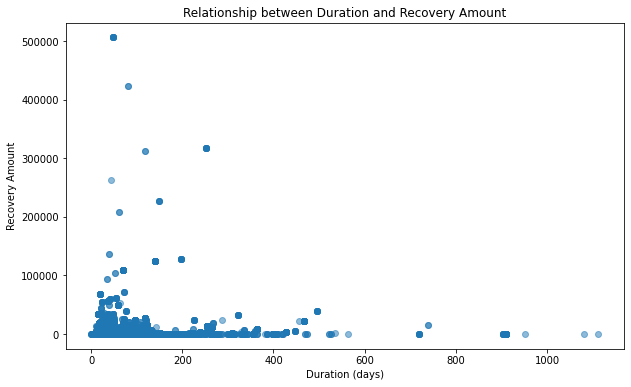

In [0]:
# Visualization 4: Relationship between Duration and Recovery Amount
if 'Resolution_Time_Days' in pandas_df.columns:
    pandas_df=pandas_df.rename(columns={'Resolution_Time_Days':'Duration'})

if 'Recovery' in pandas_df.columns:
    pandas_df['Recovery']=pd.to_numeric(pandas_df['Recovery'],errors='coerce')

if 'Duration' in pandas_df.columns and 'Recovery' in pandas_df.columns:
    valid_data=pandas_df[['Duration', 'Recovery']].dropna()
    if not valid_data.empty:
        plt.figure(figsize=(10,6))
        plt.scatter(valid_data['Duration'],valid_data['Recovery'],alpha=0.5)
        plt.xlabel('Duration (days)')
        plt.ylabel('Recovery Amount')
        plt.title('Relationship between Duration and Recovery Amount')
        plt.show()
    else:
        print("No valid data to plot after removing null values in 'Duration' and 'Recovery'.")
else:
    print("'Duration' or 'Recovery' column is missing.")

## Analyzing Complaint Counts by Reason

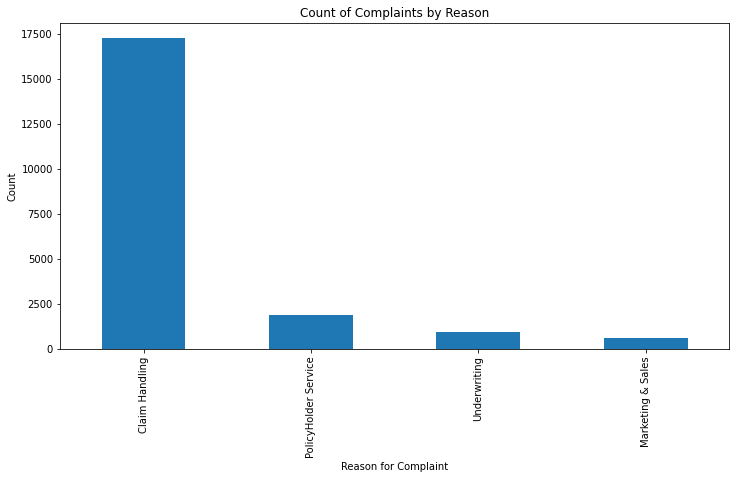

In [0]:
# Visualization 5: Count of Complaints by Reason
if 'Reason' in pandas_df.columns and not pandas_df['Reason'].isnull().all():
        plt.figure(figsize=(12,6))
        pandas_df['Reason'].value_counts().plot(kind='bar')
        plt.xlabel('Reason for Complaint')
        plt.ylabel('Count')
        plt.title('Count of Complaints by Reason')
        plt.xticks(rotation=90)
        plt.show()

## Visualizing Correlation Between Numerical Features

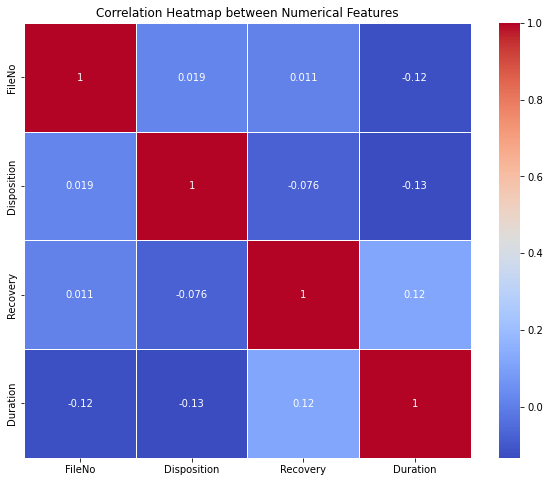

In [0]:
# Visualization 6: Heatmap of Correlation between Numerical Features
plt.figure(figsize=(10,8))
sns.heatmap(pandas_df.corr(),annot=True,cmap='coolwarm',linewidths=0.5)
plt.title('Correlation Heatmap between Numerical Features')
plt.show()

## Visualizing Complaint Flow with a Sunburst Chart

In [0]:
# Visualization 7: (Sunburst Chart) Complaint Flow from Reason to Disposition to Conclusion
import plotly.express as px

sunburst_data=pandas_df.groupby(['Reason','Disposition','Conclusion']).size().reset_index(name='Count')

fig=px.sunburst(
    sunburst_data,
    path=['Reason','Disposition','Conclusion'],  
    values='Count',  
    title="Complaint Flow: Reason → Disposition → Conclusion",
    color='Reason',  
    color_discrete_sequence=px.colors.qualitative.Set3  
)

fig.update_layout(
    width=1000,  
    height=800,  
    title_font_size=16,
    margin=dict(t=50, l=50, r=50, b=50)  
)

fig.show()

/databricks/python/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
/databricks/python/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
/databricks/python/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)


## Preparing Data for Machine Learning Models

In [0]:
print(pandas_df.columns)

# Preparing the feature matrix and target vector
X=pandas_df.drop(columns=['Disposition', 'FileNo'])  
y=pandas_df['Disposition']

# Encoding categorical columns and splitting the data into training, validation, and test sets
categorical_cols=['Company','Coverage','SubCoverage','Reason','SubReason','Conclusion','Status']
for col in categorical_cols:
    le=LabelEncoder()
    X[col]=le.fit_transform(X[col])

X_train,X_temp,y_train,y_temp=train_test_split(X,y,test_size=0.4,random_state=42)
X_val,X_test,y_val,y_test=train_test_split(X_temp,y_temp,test_size=0.5,random_state=42)

Index(['Company', 'FileNo', 'Coverage', 'SubCoverage', 'Reason', 'SubReason',
       'Disposition', 'Conclusion', 'Recovery', 'Status', 'Duration'],
      dtype='object')


## Importing Libraries for Machine Learning and Model Evaluation

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, datediff, to_date
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Preparing Data for Model Training

In [0]:
# We are preparing the feature matrix (X) and target vector (y)
X=pandas_df.drop(columns=['Disposition', 'FileNo'])  # Dropping 'File No.' as it is an identifier
y=pandas_df['Disposition']

# Encoding categorical columns and splitting the data into training, validation, and test sets
categorical_cols=['Company','Coverage','SubCoverage','Reason','SubReason','Conclusion','Status']
for col in categorical_cols:
    le=LabelEncoder()
    X[col]=le.fit_transform(X[col])

X_train,X_temp,y_train,y_temp=train_test_split(X,y,test_size=0.4,random_state=42)
X_val,X_test,y_val,y_test=train_test_split(X_temp,y_temp,test_size=0.5,random_state=42)


## Training and Evaluating Multiple Machine Learning Models

In [0]:
# Defining the models to train and evaluate
models={
    "Random Forest": RandomForestClassifier(n_estimators=100,random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000,random_state=42),
    "Support Vector Classifier": SVC(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100,random_state=42)
}

# Training and evaluating each model, storing the results for comparison
results=[]
for model_name, model in models.items():
    print(f"\nTraining and evaluating {model_name}...")
    model.fit(X_train,y_train)
    
    y_val_pred=model.predict(X_val)
    val_accuracy=accuracy_score(y_val,y_val_pred)
    print(f'{model_name} Validation Accuracy: {val_accuracy:.2f}')
    
    print(f'\n{model_name} Validation Classification Report:')
    print(classification_report(y_val,y_val_pred,target_names=[str(cls) for cls in LabelEncoder().fit(y).classes_]))
    
    y_test_pred=model.predict(X_test)
    test_accuracy=accuracy_score(y_test,y_test_pred)
    print(f'\n{model_name} Test Accuracy: {test_accuracy:.2f}')
    
    print(f'\n{model_name} Test Classification Report:')
    print(classification_report(y_test,y_test_pred,target_names=[str(cls) for cls in LabelEncoder().fit(y).classes_]))
    
    results.append({
        'Model': model_name,
        'Validation Accuracy': val_accuracy,
        'Test Accuracy': test_accuracy
    })



Training and evaluating Random Forest...
Random Forest Validation Accuracy: 0.90

Random Forest Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.92      0.96      0.94      1423
           2       0.93      0.86      0.89       361
           3       0.92      0.94      0.93      1462
           4       0.70      0.64      0.67        22
           5       0.79      0.73      0.76       217
           6       0.00      0.00      0.00         4
           7       0.96      0.77      0.86        35
           8       0.84      0.72      0.78        72
           9       0.89      0.88      0.88        73
          10       0.85      0.81      0.83       444
          11       0.33      0.33      0.33         6
          12       0.67      0.40      0.50         5
          13       0.67      0.50      0.57        16

    accuracy                           0.90      4148
   

/databricks/python/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Logistic Regression Validation Accuracy: 0.54

Logistic Regression Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.77      0.62      0.68      1423
           2       0.00      0.00      0.00       361
           3       0.47      0.94      0.63      1462
           4       0.00      0.00      0.00        22
           5       0.07      0.02      0.03       217
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00        35
           8       0.00      0.00      0.00        72
           9       0.00      0.00      0.00        73
          10       0.08      0.00      0.01       444
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00        16

    accuracy                           0.54      4148
   macro avg       0.10      0.11

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




Support Vector Classifier Test Accuracy: 0.54

Support Vector Classifier Test Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.83      0.56      0.67      1391
           2       0.00      0.00      0.00       349
           3       0.45      0.98      0.62      1490
           4       0.00      0.00      0.00        27
           5       1.00      0.01      0.02       211
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00        43
           8       0.00      0.00      0.00        70
           9       0.00      0.00      0.00        82
          10       0.00      0.00      0.00       451
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00        14

    accuracy                           0.54      4148
   macro avg       0.16      0.1

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Gradient Boosting Validation Accuracy: 0.85

Gradient Boosting Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.90      0.92      0.91      1423
           2       0.90      0.79      0.84       361
           3       0.84      0.91      0.87      1462
           4       0.89      0.73      0.80        22
           5       0.71      0.47      0.57       217
           6       0.00      0.00      0.00         4
           7       0.93      0.80      0.86        35
           8       0.78      0.62      0.69        72
           9       0.94      0.88      0.91        73
          10       0.77      0.75      0.76       444
          11       0.43      0.50      0.46         6
          12       0.44      0.80      0.57         5
          13       0.64      0.56      0.60        16

    accuracy                           0.85      4148
   macro avg       0.73      0.69    

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted sa

## Visualizing Model Validation Accuracy

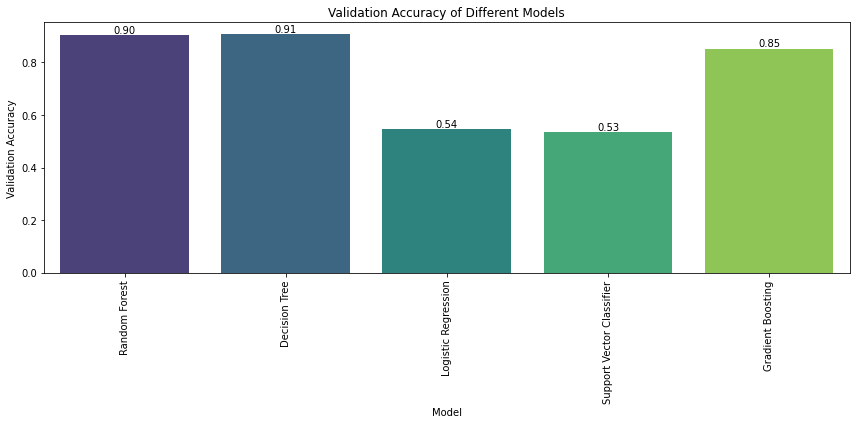

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

results_df=pd.DataFrame(results)

# Plotting the validation accuracy of different models with annotations
plt.figure(figsize=(12, 6))
ax=sns.barplot(x='Model',y='Validation Accuracy',data=results_df,palette='viridis')
plt.title('Validation Accuracy of Different Models')
plt.xticks(rotation=90)

# Adding accuracy values on top of the bars
for bar in ax.patches:
    height=bar.get_height()
    if height>0:  
        ax.text(
            bar.get_x() + bar.get_width() / 2,  
            height,  
            f'{height:.2f}',  
            ha='center', va='bottom', fontsize=10, color='black' 
        )
plt.tight_layout()
plt.show()




## Visualizing Model Test Accuracy

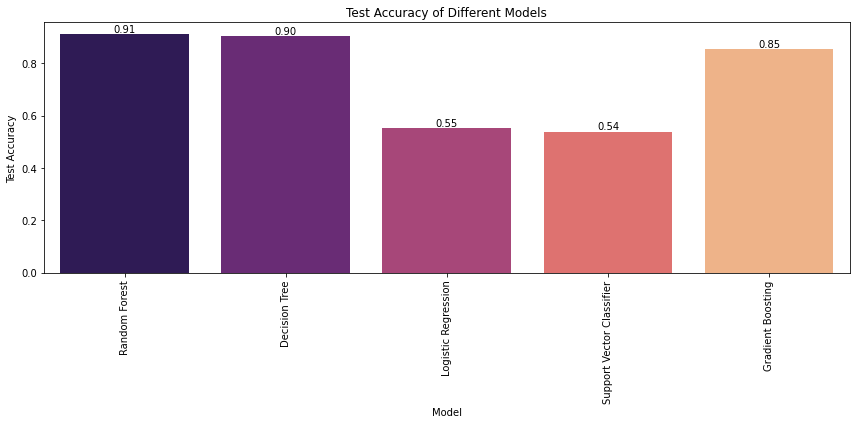

In [0]:
# Plotting the test accuracy of different models with annotations
plt.figure(figsize=(12, 6))
ax=sns.barplot(x='Model',y='Test Accuracy',data=results_df,palette='magma')
plt.title('Test Accuracy of Different Models')
plt.xticks(rotation=90)

# Adding accuracy values on top of the bars
for bar in ax.patches:
    height=bar.get_height()
    if height > 0: 
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            height,
            f'{height:.2f}', 
            ha='center', va='bottom', fontsize=10, color='black'  
        )
plt.tight_layout()
plt.show()

## Analyzing Feature Importance Using Random Forest

Features in X: Index(['Company', 'Coverage', 'SubCoverage', 'Reason', 'SubReason',
       'Conclusion', 'Recovery', 'Status', 'Duration'],
      dtype='object')


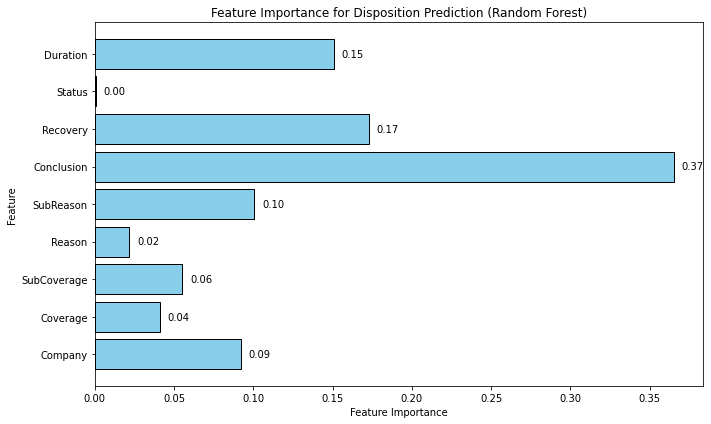

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Encoding 'Status' and adding it to the feature matrix
if 'Status' in pandas_df.columns:
    le=LabelEncoder()
    pandas_df['StatusEncoded']=le.fit_transform(pandas_df['Status'])
    X['Status']=pandas_df['StatusEncoded']

print("Features in X:", X.columns)

# Training the Random Forest model and plotting feature importances
rf_model=RandomForestClassifier(n_estimators=100,random_state=42)
rf_model.fit(X_train, y_train)

# Plotting feature importance for disposition prediction
plt.figure(figsize=(10,6))
features_importance=rf_model.feature_importances_
ax=plt.barh(X.columns, features_importance,color='skyblue',edgecolor='black')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Disposition Prediction (Random Forest)')

# Adding feature importance values on the bars
for bar,importance in zip(ax,features_importance):
    plt.text(
        bar.get_width() + 0.005,  
        bar.get_y() + bar.get_height() / 2, 
        f'{importance:.2f}',
        ha='left', va='center', fontsize=10, color='black' 
    )

plt.tight_layout()
plt.show()



## Visualizing Feature Correlations with a Heatmap

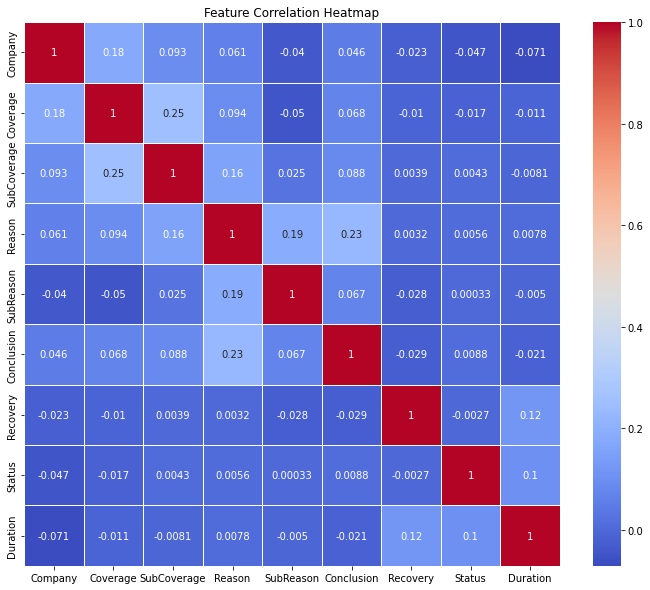

In [0]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(),annot=True,cmap='coolwarm',linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

### Converting Pandas DataFrame Back to Spark DataFrame 

In [0]:
# Converting back to Spark DataFrame 
spark_df=spark.createDataFrame(pandas_df)

## Training, Evaluating, and Storing Model Performance

In [0]:
# Training and evaluating each model, storing results for comparison
results=[]
for model_name,model in models.items():
    print(f"\nTraining and evaluating {model_name}...")
    model.fit(X_train,y_train)
    
    y_val_pred=model.predict(X_val)
    val_accuracy=accuracy_score(y_val,y_val_pred)
    print(f'{model_name} Validation Accuracy: {val_accuracy:.2f}')
    
    y_test_pred=model.predict(X_test)
    test_accuracy=accuracy_score(y_test,y_test_pred)
    print(f'{model_name} Test Accuracy: {test_accuracy:.2f}')
    
    results.append({
        'Model': model_name,
        'Validation Accuracy': val_accuracy,
        'Test Accuracy': test_accuracy
    })

# Converting the results to a DataFrame for easy visualization
results_df=pd.DataFrame(results)

# Displaying the model accuracies
print("\nModel Accuracies:")
print(results_df)



Training and evaluating Random Forest...
Random Forest Validation Accuracy: 0.90
Random Forest Test Accuracy: 0.91

Training and evaluating Decision Tree...
Decision Tree Validation Accuracy: 0.91
Decision Tree Test Accuracy: 0.90

Training and evaluating Logistic Regression...


/databricks/python/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Logistic Regression Validation Accuracy: 0.54
Logistic Regression Test Accuracy: 0.55

Training and evaluating Support Vector Classifier...
Support Vector Classifier Validation Accuracy: 0.53
Support Vector Classifier Test Accuracy: 0.54

Training and evaluating Gradient Boosting...
Gradient Boosting Validation Accuracy: 0.85
Gradient Boosting Test Accuracy: 0.85

Model Accuracies:
                       Model  Validation Accuracy  Test Accuracy
0              Random Forest             0.903327       0.910318
1              Decision Tree             0.906943       0.903809
2        Logistic Regression             0.544841       0.553279
3  Support Vector Classifier             0.533992       0.539055
4          Gradient Boosting             0.852941       0.854629


## Performing PCA and Visualizing the Results

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning:

toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field pca_features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.



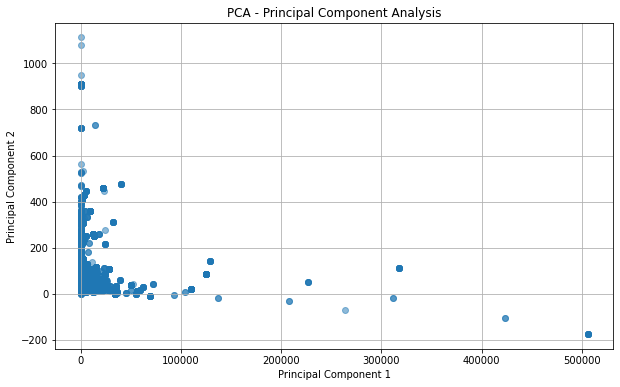

In [0]:
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt

# Performing PCA to reduce dimensionality using 'Resolution_Time_Days' and 'Recovery'
spark=SparkSession.builder.appName("PCA Example").getOrCreate()

df=spark.createDataFrame(pandas_df)

feature_columns=['Duration','Recovery']  

vector_assembler=VectorAssembler(inputCols=feature_columns,outputCol="features")
insurance_features=vector_assembler.transform(df)

# Plotting the results of the PCA transformation
pca=PCA(k=2,inputCol='features',outputCol='pca_features')
pca_model=pca.fit(insurance_features)
insurance_pca=pca_model.transform(insurance_features)

pandas_pca_df=insurance_pca.select('pca_features').toPandas()

pca_features_array=np.array(pandas_pca_df['pca_features'].tolist()) 
plt.figure(figsize=(10,6))
plt.scatter(pca_features_array[:, 0],pca_features_array[:, 1],alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - Principal Component Analysis')
plt.grid()
plt.show()
